In [2]:
# Run these pip install lines if necessary
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00


In [3]:
# import necessary libraries

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import itertools
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from pandas.plotting import parallel_coordinates

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Please input the path of the 696_Project folder into the empty string:
root_path = "/content/drive/MyDrive/696_Project"

In [5]:
# Load in the data
data = pd.read_csv(root_path + "/Autoencoder_696/final_dataset.csv", parse_dates=True)

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Ensure the data is sorted by date
data.sort_index(inplace=True)

# Check the last date in the dataset
last_date_in_dataset = data.index[-1]
print(last_date_in_dataset)

Timestamp('2023-12-31 00:00:00')

## ARIMA Modelling Process:

We will start with a VAR (Vector autoregression) primarily for a simple and quick comparison baseline. From there, we will employ other supervised learning models and compare them to determine the optimal model for predicting 10-Year bond yields.

In [ ]:
# Split the data into train/test sets
split_ratio = 0.8
split_point = int(len(data) * split_ratio)
train = data.iloc[:split_point]
test = data.iloc[split_point:]

# Fit the VAR model on the training data
model = VAR(train)
results = model.fit(maxlags=15, ic='aic')

# forecasts
forecast = results.forecast(train.values[-results.k_ar:], steps=len(test))

# accuracy metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

c:\Users\dross\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 304989.8688809657
MSE: 993297978641.3547
RMSE: 996643.3557905027
MAPE: 120.5056836388175%


The relationship between economic parameters such as GDP growth, unemployment, and inflation is shown by analyzing the residual data that our model did not account for accurately. The residuals are indicators that let us assess the performance of our model and identify areas for improvement. Notice the clustering of robust correlations in the bottom left of the matrix on page 3. This illustrates which factors have a bias, moving in correlation or in opposite directions. Debt-to-GDP and debt holdings, for example, appear to be closely related, responding in a similar manner to economic changes. This suggests that they might be subject to the same factors or that they might both respond to the same economic measures.

The heatmap is an initial reference guide for understanding the variables influencing bond yields. However, it only displays the linear relationships between pairs. To fully grasp these relationships, we must unravel the intricate, curved relationships and their interactions.

In [ ]:
# correlation matrix to help me understand the pair-wise relationship of the data
residuals = results.resid
# Convert residuals to a DataFrame
residuals_df = pd.DataFrame(residuals)

residuals_df

,bond_yield,gdp,cpi,cpi_e,unemploy,pcepi,ffr,tbill_6,tria_c_bond,c_bond_idx,...,s_idx,nasdag,gd_issue,m1,m2,d_t_gdp,debt,d_hold,budget,oil
date,,,,,,,,,,,,,,,,,,,,,
2003-01-16,-0.011041,-5048.159303,-0.038337,-0.012021,-0.004434,-0.014606,-0.061562,-0.008136,0.011545,0.019772,...,-0.055966,-15.149488,-480.104834,-5.973214,-2.320406,-0.013221,-3241.909089,-1086.297865,6314.340847,0.221469
2003-01-17,-0.068292,-3784.788387,-0.065338,0.005686,0.001829,-0.025938,-0.034769,-0.010981,0.010618,0.016909,...,-0.297062,-44.327023,319.181814,-2.510110,-1.066939,0.032128,-2388.009448,-1040.266740,1960.303558,-0.093256
2003-01-18,-0.007245,-243.366784,0.017228,-0.010194,0.004337,0.000617,-0.009921,0.010394,0.021308,-0.000902,...,-0.005995,-1.004968,-25.322228,-2.798016,-1.703492,0.046285,4725.803148,4239.253195,2695.912346,0.253737
2003-01-19,-0.022528,-528.559043,-0.008983,-0.005222,-0.005493,-0.004891,-0.015772,-0.011799,0.014641,0.001262,...,-0.116056,-7.535248,-44.727914,-5.567362,-1.217548,0.012729,-1933.791195,-3385.679347,4035.434567,0.100109
2003-01-20,-0.016070,-2873.724875,-0.059422,-0.005427,-0.000192,-0.020668,-0.017871,-0.007318,0.002015,0.011263,...,0.000852,4.376021,142.006858,5.451067,-10.039151,-0.038115,-10501.994756,-8663.471818,4272.161918,-0.041908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15,0.035413,-628.766771,-0.002080,0.016328,0.001871,0.001828,0.062283,-0.014105,-0.010107,-0.025821,...,0.994053,65.284291,238.154089,0.261171,5.081747,-0.024000,-3464.663500,-2359.591390,-652.556499,-0.154790
2019-10-16,-0.002841,6266.975853,0.015796,0.017725,-0.016646,0.008464,0.013216,-0.017346,-0.025222,0.008978,...,-0.144662,-13.809722,-95.345982,7.541580,-4.012479,-0.056444,4602.566836,3154.419088,-4364.715673,0.337675
2019-10-17,-0.004055,4435.506243,-0.028249,0.015167,-0.008501,-0.003387,0.003366,-0.006405,-0.014146,-0.003190,...,0.435143,27.525984,145.385882,3.946395,-1.368956,-0.031646,3936.527264,1084.546686,-3982.831740,-0.111304


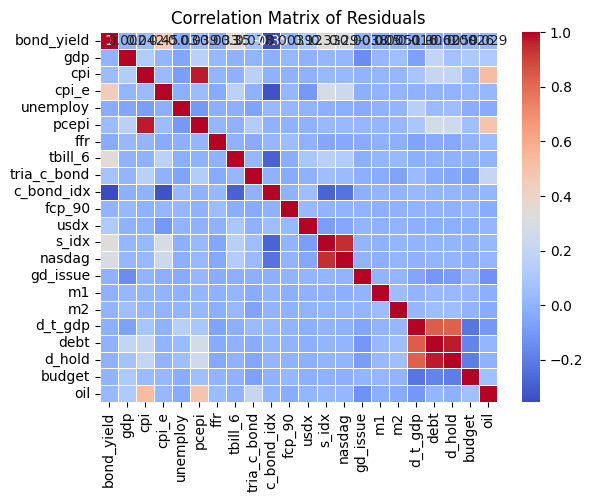

In [ ]:
# correlation matrix to help me understand the pair-wise relationship of the data
residuals = results.resid
# Convert residuals to a DataFrame
residuals_df = pd.DataFrame(residuals)
# Compute the correlation matrix of residuals
residuals_correlation_matrix = residuals_df.corr()
# Visualize the correlation matrix
sns.heatmap(residuals_correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Residuals')
plt.show()

Correlation matrix for linear relationship is useful, but will need a deeper dive for feature extraction. To improve the VAR preformace we used a RandomForestRegressor to extract the features with high importance, i.e. a high weight. This is of interest as we want to know which factors are driving features that influence bond yield forecasts.

In [ ]:
X = data.drop(['bond_yield'], axis=1)
y = data['bond_yield']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importances = model.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]

# Print the features and their importances
for index in sorted_indices:
    print(f"{X.columns[index]}: {importances[index]}")

tria_c_bond: 0.8134907069799333
unemploy: 0.08254563287971757
c_bond_idx: 0.022319285557247766
tbill_6: 0.013635564687591263
pcepi: 0.011303071225456122
ffr: 0.008549556281450278
cpi: 0.008451241681786806
oil: 0.007067506048956424
d_hold: 0.005981616912106863
debt: 0.005223813128658843
cpi_e: 0.0044258656862124195
fcp_90: 0.003940959528458108
s_idx: 0.003546392319788444
usdx: 0.0021773759039269507
gd_issue: 0.0021764405981132494
nasdag: 0.0014258945182197844
m1: 0.0012407512351791472
m2: 0.0011037598452647564
budget: 0.00067496781505822
d_t_gdp: 0.000528545061557768
gdp: 0.00019105210531584482


Now that we have uncovered the hidden mysteries by examining feature significance scores, which show the specific impact of economic indicators such as Treasury inflation-protected securities (TIPS) and the unemployment rate on predicting changes in bond yields. We will use feature ablation, removing the less important features that simplify the model and reduce its complexity, making it less prone to overfitting and improving its generalizability.


In [ ]:
#VAR for comparsion used RF regressor to improve performance
df = data[['tria_c_bond','unemploy','c_bond_idx','tbill_6','pcepi']]
n_obs = len(df)
train_size = int(n_obs * 0.8)
train, test = df[0:train_size], df[train_size:]

# Fit the VAR model on the training data
var_model = VAR(train)
var_results = var_model.fit(maxlags=15, ic='bic')

# Forecast
forecast_steps = n_obs - train_size
forecast = var_results.forecast(train.values[-var_results.k_ar:], steps=forecast_steps)

# Convert the forecast to a DataFrame
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

metrics_df1 = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'Value': [mae, mse, rmse, mape]
})

metrics_df1['Model Type'] = 'VAR'

c:\Users\dross\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
forecast = results.forecast(train.values[-results.k_ar:], steps=len(test))

# accuracy metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

metrics_df1 = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'Value': [mae, mse, rmse, mape]
})

metrics_df1['Model Type'] = 'VAR'

AttributeError: 'tuple' object has no attribute 'forecast'

When we fit the VAR with features of greater importance, we find a significant improvement.

We will go into detail for each statistic we chose to measure performance:

**MAE (2.43)** indicates that, on average, projected values are approximately 2.43 units off from actual values. Typically, a lower range indicates optimal bond yields, which typically range from. 49 to 5.248. This indicates an opportunity for improvement.

**MSE (18.19)** and **RMSE (4.27)** are metrics that penalize larger errors more than smaller ones since they square the errors before averaging them.
An RMSE of 4.27 indicates that the standard deviation of prediction errors is approximately 4.27 units. This is a substantial error in deviation. We are hoping to get the error down to the tenths.

The **MAPE (204.57%)** indicates that, on average, projected values differ from actual values by more than 200%. A MAPE value of 204.57% is very high, implying that the model's predictions are twice as far from the actual bond yield, indicating low predictive accuracy and much potential for improvement.

There is still more room for improvement, but these metrics will provide a comprehensive failure analysis for this model and the future model's performance. Now that we have a baseline, let's try our first supervised learning model, ARIMA, and see if we can improve performance.


An ARIMA (Autoregressive Integrated Moving Average) model is a great choice because it works well with single variables of interest, such as bond rates. ARIMA's model is simpler with fewer parameters, making it easier to understand the factors that influence forecasts. But before we begin, we need to ensure the data is stationary. The Arima model suggests that our time series data is stable, which means that statistics such as mean and variance remain constant over time. This is essential if the data includes trends or other kinds of statistical variation, as the ARIMA will not produce an appropriate forecast. To test this, we'll employ an Augmented Dickey Fuller (ADF). This test will determine whether or not an ARIMA has a unit root, implying that the model is non-stationary. The ADF statistic is well below the value, which is strong evidence of stationary; otherwise, we would need to first difference the data once or multiple times until stationary was attained. The Arima has three parameters:

`P` parameter: which specifies the number of lagged observations used to capture associations.

`D` parameter: indicates how much differencing was required to obtain stationary
since we passed the ADF, the D parameter will initially be set to zero.

`Q` parameter: is a moving average, which helps to account for random error variations.


In [ ]:
# Differencing the time series
data['bond_yield_diff'] = data['bond_yield'].diff().dropna()

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(data['bond_yield_diff'].dropna())
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')

for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.189489
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


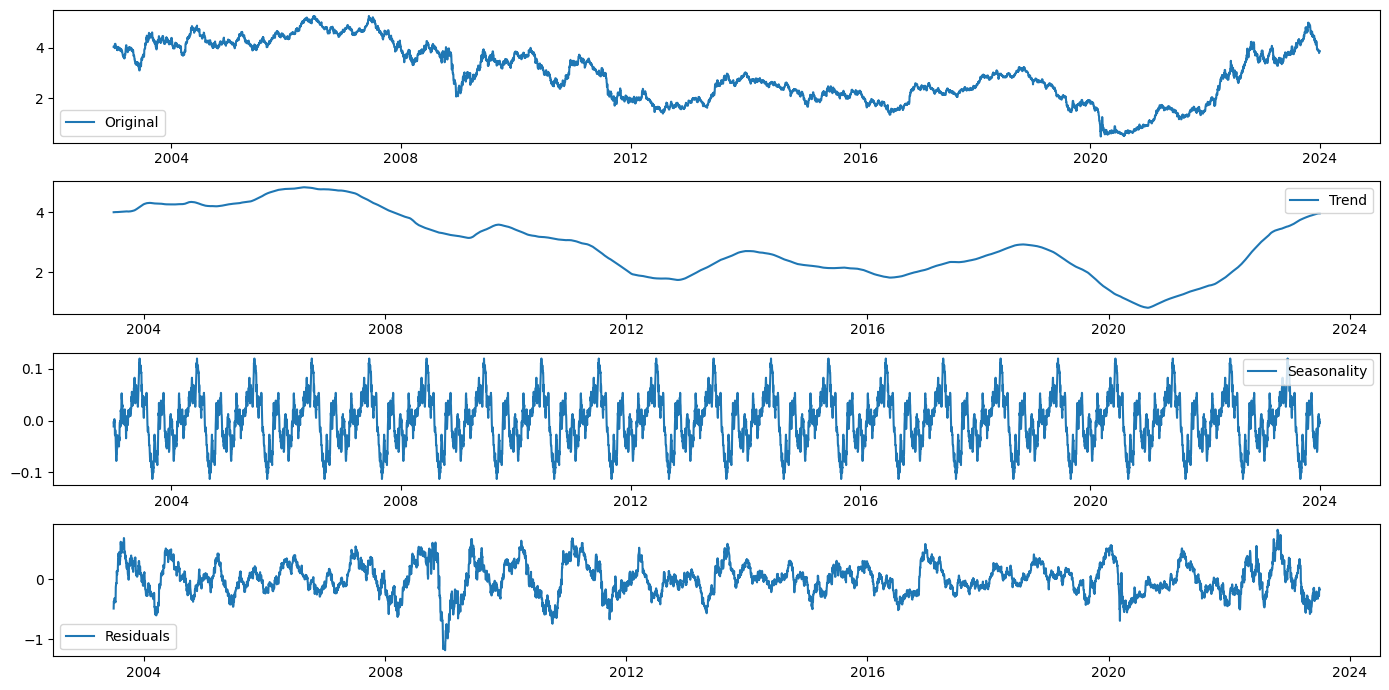

In [ ]:
#Change to your file path
df1 = pd.read_csv(root_path + "/Autoencoder_696/final_dataset.csv", index_col='date', parse_dates=True)

# We'll use the 'bond_yield' as the time series data for seasonality check
bond_yield_ts = df1['bond_yield']

# Decomposing the time series to observe its components
decomposition = sm.tsa.seasonal_decompose(bond_yield_ts, model='additive', period=365)  # Assuming daily data

# Plotting the decomposed time series components
plt.figure(figsize=(14, 7))
plt.subplot(411)
plt.plot(bond_yield_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We first tried taking the suggested Auto ARIMA and forcing the approach for tuning my parameters with this method took up alot of time. But it provided a (p,d,q) of (4,1,0) The issues was the MAE was too High (1.2)

In [ ]:
#After EDA my best model (4,1,0)
auto_arima_model = auto_arima(data['bond_yield'],
                              start_p=3, max_p=5,  # Exploring around p=4
                              d=1,                 # Keeping d constant as it's the differencing order
                              start_q=0, max_q=2,  # Exploring around q=0
                              seasonal=False,      # No seasonal component as per the best model
                              stepwise=True,       # Using stepwise search for efficiency
                              trace=True,          # To print the fit of each model tried
                              error_action='ignore',
                              suppress_warnings=True,
                              information_criterion='aic')


lst = list(data.columns)
results = ()
for x in lst:
    time_series = data['bond_yield']
# Decide the size of the split
split_ratio = 0.8
split_index = int(len(time_series) * split_ratio)
# Split the data into train and test sets
train_data = time_series[:split_index]
test_data = time_series[split_index:]
# Fit the ARIMA model on the training set
arima_model = ARIMA(train_data, order=(4, 1, 0))
arima_results = arima_model.fit()

# Forecast
forecast = arima_results.forecast(steps=len(test_data))

# Calculating the errors using 'test_data' instead of 'test'
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

metrics_df2 = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'Value': [mae, mse, rmse, mape]
})

metrics_df2['Model Type'] = 'AUTO_ARIMA'

Performing stepwise search to minimize aic
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-24966.308, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24964.403, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24963.054, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24963.096, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24966.401, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24963.632, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.868 seconds


We also utilised the approach of trying varying combinations of `p,q,q` parameters, similar to using GridSearchCV, and our process for selecting our parameters was very time and computationally EXPENSIVE to run locally overnight. You can run if you like just uncomment the loop, but I got an (p,d,q) of (6,3,7).


In [ ]:
# Define the parameter range
p = d = q = range(0,18)  # Example ranges, adjust based on your dataset
pdq_combinations = list(itertools.product(p, d, q))
# Split your data into train and test sets
train = data.iloc[:split_point]
test = data.iloc[split_point:]
min_mae = float('inf')
best_params = None
#UNCOMMENT
#for combination in  pdq_combinations:
    try:
        model = ARIMA(train['bond_yield'], order=combination)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))

        mae = mean_absolute_error(test['bond_yield'], forecast)
        if mae < min_mae:
            min_mae = mae
            best_params = combination
    except:
        continue
print(f"Best ARIMA parameters: {best_params} with MAE: {min_mae}")

lst = list(data.columns)
results = ()
for x in lst:
    time_series = data['bond_yield']
# Decide the size of the split
split_ratio = 0.8
split_index = int(len(time_series) * split_ratio)
# Split the data into train and test sets
train_data = time_series[:split_index]
test_data = time_series[split_index:]
# Fit the ARIMA model on the training set
arima_model = ARIMA(train_data, order=(6, 3, 7))
arima_results = arima_model.fit()
# Print the summary
#print(arima_results.summary())
# Forecast
forecast = arima_results.forecast(steps=len(test_data))
#Best ARIMA parameters: (6, 3, 7) with MAE: 0.6331037596473985
last_14_predictions = forecast[-14:]

# The corresponding dates for these predictions would be the last 14 dates of your test_data index
last_14_dates = test_data.index[-14:]

# Create a Series for clarity, associating each prediction with its date
last_14_series = pd.Series(last_14_predictions, index=last_14_dates)

# Display the last 14 bond_yield predictions along with dates
print(last_14_series)

forecast = arima_results.forecast(steps=len(test_data))

# Calculating the errors using 'test_data' instead of 'test'
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

metrics_df3 = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'Value': [mae, mse, rmse, mape]
})

metrics_df3['Model Type'] = 'ARIMA_Grid_Serach'

In [ ]:
# Append metrics of all viewed models to original dataset.
all_metrics = pd.concat([metrics_df1,metrics_df2,metrics_df3])

transposed_df = all_metrics.pivot(index = 'Metric', columns='Model Type', values = 'Value')
transposed_df.reset_index(inplace = True)


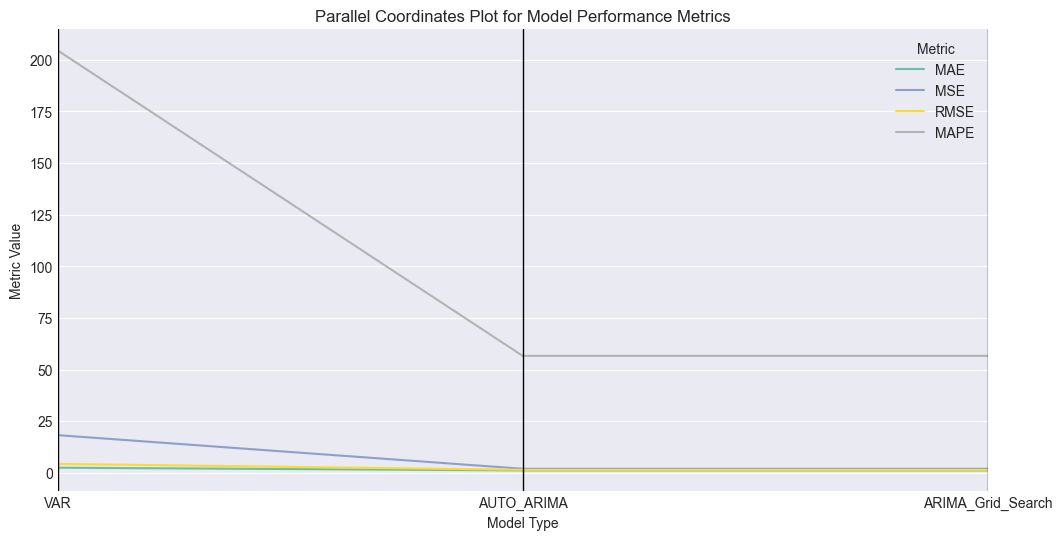

In [ ]:
transposed_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'VAR': [2.427543, 18.194680, 4.265522, 204.573738],
    'AUTO_ARIMA': [1.097980, 1.908269, 1.381401, 56.609093],
    'ARIMA_Grid_Search': [1.097980, 1.908269, 1.381401, 56.609093]
})

plt.figure(figsize=(12, 6))
parallel_coordinates(transposed_df, class_column='Metric', colormap=plt.get_cmap("Set2"))

# Set the x-axis labels in the desired order
plt.xticks(ticks=np.arange(3), labels=['VAR', 'AUTO_ARIMA', 'ARIMA_Grid_Search'])

plt.title('Parallel Coordinates Plot for Model Performance Metrics')
plt.xlabel('Model Type')
plt.ylabel('Metric Value')
plt.legend(title='Metric', loc='upper right')
plt.grid(True)

plt.show()

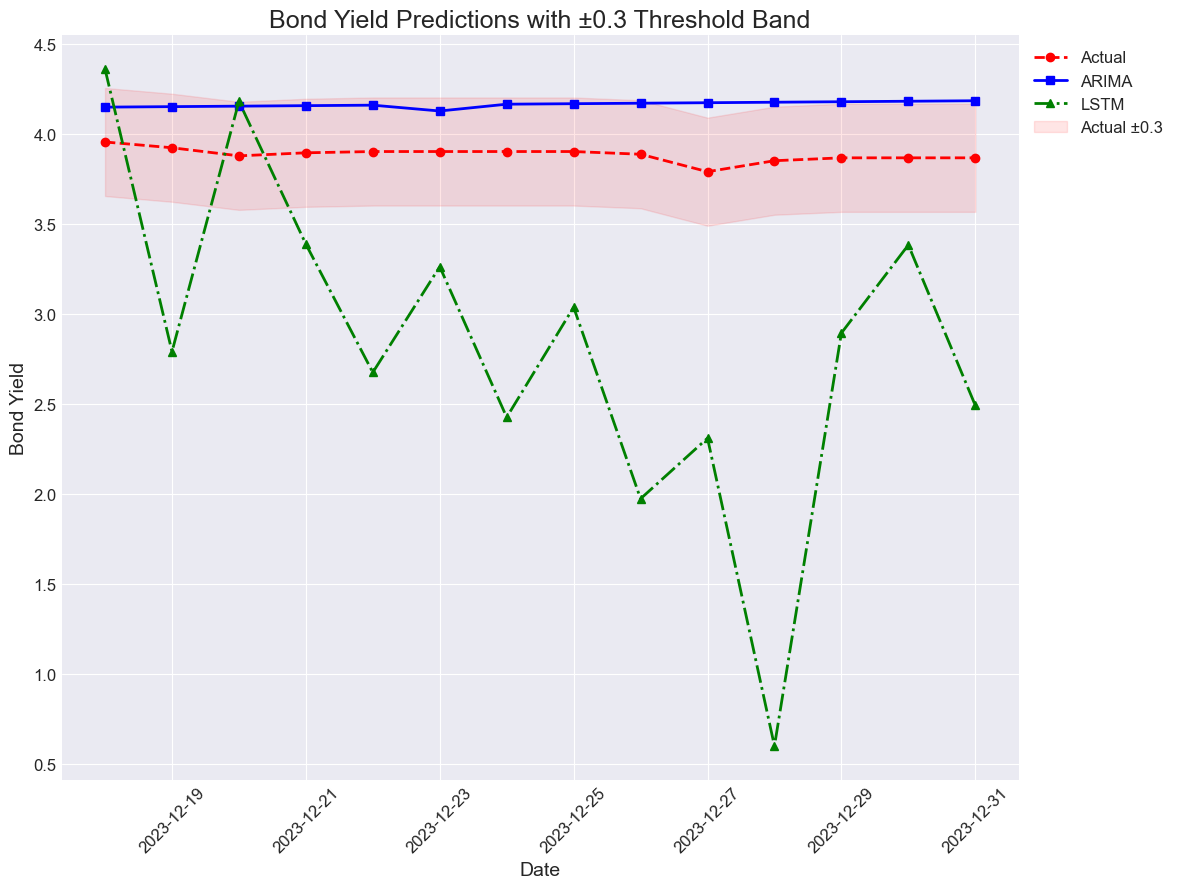

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
df = pd.read_csv('C:/Users/dross/Desktop/Project/predictions.csv')

df['Date'] = pd.to_datetime(df['Date'])

# Pivot the DataFrame to get 'Type'
df_pivoted = df.pivot(index='Date', columns='Type', values='bond yield')

# Creating the plot
plt.figure(figsize=(14, 9))

# Plot each prediction type with custom colors, line styles, and markers
plt.plot(df_pivoted.index, df_pivoted['ACTUAL'], label='Actual', color='red', linewidth=2, linestyle='--', marker='o', markersize=6)
plt.plot(df_pivoted.index, df_pivoted['ARIMA'], label='ARIMA', color='blue', linewidth=2, linestyle='-', marker='s', markersize=6)
plt.plot(df_pivoted.index, df_pivoted['LSTM'], label='LSTM', color='green', linewidth=2, linestyle='-.', marker='^', markersize=6)

# Adding the threshold band around 'Actual'
plt.fill_between(df_pivoted.index, (df_pivoted['ACTUAL'] - 0.3).values, (df_pivoted['ACTUAL'] + 0.3).values, color='red', alpha=0.1, label='Actual ±0.3')

# Enhancements for readability and appearance
plt.title('Bond Yield Predictions with ±0.3 Threshold Band', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Bond Yield', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust for legend outside

plt.show()

Now that we've completed our pre-work, we can begin fitting the model; To save time, we conducted an auto-arima and employed a supervised learning technique known as an exhaustive grid search. From there, we compare the two and select the optimal parameters. The grid search enables a systematic approach for evaluating hyperparameter combinations. Its drawback is its computational cost, which can be significant. In our case, we are running this on great lakes, so the cost is not an issue.


The auto offered optimal parameters of (4,1,0) while the grid was (6,3,7).


When fitting and testing, the grid parameters performed best, with MAE of.633, MSE of.58, and RSME of.76. This is a significant improvement over our VAR scores, and it looks even more promising in cross-validation, where the average MAE is.03, indicating that our model will generalize well. So, we will compare the LSTM to our ARIMA to determine which performs better.


In [ ]:
initial_train_size = int(len(data) * 0.8)
validation_size = len(data) - initial_train_size

# Store metrics
mae_scores = []
#walk-forward validation EXPENSIVE took about 236mins ran locally to run uncomment
#for i in range(validation_size):
    train = data.iloc[:initial_train_size + i]
    test = data.iloc[initial_train_size + i:initial_train_size + i + 1]
    # Fit the ARIMA model
    model = ARIMA(train['bond_yield'], order=(6, 3, 7))
    model_fit = model.fit()
    # Forecast
    forecast = model_fit.forecast(steps=1)
    # Calculate and store the MAE
    mae = mean_absolute_error(test['bond_yield'], forecast)
    mae_scores.append(mae)
# Calculate the average MAE across all forecasts
average_mae = sum(mae_scores) / len(mae_scores)
print(f'Average MAE: {average_mae}')
#Average MAE: 0.034639522327100075

Average MAE: 0.034639522327100075
